In [19]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from typing import Tuple
import numpy as np
import matplotlib.pyplot as plt

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED=42
torch.manual_seed(SEED)

In [3]:
## using the provided resource as base architecture
class VAE(nn.Module):
    def __init__(self, hidden_dims, data_dim=784, device=DEVICE):
        super().__init__()
        assert len(hidden_dims) == 5, "Insufficiently number of dimensions!"
        self.data_dim = data_dim
        self.device = device
        # define IO
        self.in_layer = nn.Linear(data_dim, hidden_dims[0])
        self.out_layer = nn.Linear(hidden_dims[-1], data_dim)
        # hidden layer
        self.enc_h = nn.Linear(hidden_dims[0], hidden_dims[1])
        # define hidden and latent
        self.enc_mu = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.enc_sigma = nn.Linear(hidden_dims[1], hidden_dims[2])
        # hidden layer decoder
        self.dec_h = nn.Linear(hidden_dims[2], hidden_dims[-2])
        self.dec_layer = nn.Linear(hidden_dims[-2], hidden_dims[-1])
        self.to(device)

    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        h1 = F.relu(self.in_layer(x))
        h2 = F.relu(self.enc_h(h1))
        return self.enc_mu(h2), self.enc_sigma(h2)

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        h3 = F.relu(self.dec_h(z))
        h4 = F.relu(self.dec_layer(h3))
        return torch.sigmoid(self.out_layer(h4))

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        mu, logvar = self.encode(x.view(-1, self.data_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [4]:
def train(model: VAE, epoch: int, train_loader: torch.utils.data.DataLoader, log_interval: int=25) -> list:
    model.train()
    train_loss = 0.
    train_loss_vals = []
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(model.device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(x)
        loss_val, ce, kld = loss(recon_batch, x, mu, logvar)
        loss_val.backward()
        train_loss += loss_val.item()
        train_loss_vals.append(loss_val.item())
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(f"Train epoch={epoch} [{batch_idx*len(x)}/{len(train_loader.dataset)}]\t loss={loss_val.item() / len(x)}")
            print(f"BCE={ce} KLD={kld}")
    print(f"===> epoch={epoch} avrg.loss={train_loss/len(train_loader.dataset)}")
    return train_loss_vals

In [5]:
def test(model: VAE, epoch: int, test_loader: torch.utils.data.DataLoader) -> list:
    model.eval()
    test_loss = 0.
    test_loss_vals = []
    with torch.no_grad():
        for i, (x, _) in enumerate(test_loader):
            x = x.to(model.device)
            recon_batch, mu, logvar = model(x)
            test_loss_val, ce, kld = loss(recon_batch, x, mu, logvar)
            test_loss += test_loss_val.item()
            test_loss_vals.append(test_loss_val.item())
            # if i == 0: # TODO: do we want to persist images here?
            #     n = min(data.size(0), 8)
            #     comparison = torch.cat([x[:n], ])
    test_loss /= len(test_loader.dataset)
    print(f"===> Test loss={test_loss}")
    return test_loss_vals

In [27]:
# lets use torch datasets with our data
class DatasetWrapper(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


mnist_train = np.loadtxt("/content/mnist_train.csv", delimiter=",", dtype=np.float32)
mnist_test = np.loadtxt("/content/mnist_test.csv", delimiter=",", dtype=np.float32)
train_labels = mnist_train[:,0]
train_data = mnist_train[:,1:] / 255.0
test_labels = mnist_test[:,0]
test_data = mnist_test[:,1:] / 255.0

train_data.shape, test_data.shape

train_ds = DatasetWrapper(train_data, train_labels)
test_ds = DatasetWrapper(test_data, test_labels)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=True)

import numpy as np

def transform_data(data, scale_factor=0.3, threshold=0.1, min_value=0.1):
    # Scale the pixel values
    #data = np.clip(data + scale_factor, 0, 1)

    # Apply thresholding
    data[data < threshold] = min_value

    return data

# Apply the transformation to your data
train_data_transformed = transform_data(train_data)
test_data_transformed = transform_data(test_data)

beta_train = DataLoader(DatasetWrapper(train_data_transformed, train_labels), batch_size = 256, shuffle=True)
beta_test = DataLoader(DatasetWrapper(test_data_transformed, test_labels), batch_size = 256, shuffle=True)

In [24]:
# Compute the normalisation constant from the paper
def C0(Lambda: torch.Tensor) -> torch.Tensor:

    # atanh unstable around 0 and 1
    eps = 0.0002
    Lambda = torch.clamp(Lambda, eps, 1-eps)
    norm_const = torch.where(Lambda == 0.5, torch.tensor(2.),
                             ( 2 * torch.atanh( 1 - 2 * Lambda) )/( 1 - 2 * Lambda + eps) )

    return norm_const

def C(Lambda: torch.Tensor) -> torch.Tensor:
    eps = 1e-3  # Adjust the epsilon value
    Lambda = torch.clamp(Lambda, eps, 1 - eps)

    # Handling values close to 0.5 more carefully
    close_to_half = torch.isclose(Lambda, torch.tensor(0.5), atol=eps)
    far_from_half = ~close_to_half

    # Use a more stable approach for values close to 0.5
    norm_const_close = torch.tensor(2.)  # or some other stable calculation

    # Original calculation for values far from 0.5
    norm_const_far = (2 * torch.atanh(1 - 2 * Lambda[far_from_half])) / (1 - 2 * Lambda[far_from_half])

    # Combine results
    norm_const = torch.zeros_like(Lambda)
    norm_const[close_to_half] = norm_const_close
    norm_const[far_from_half] = norm_const_far

    return norm_const


# Compute the negative log likelihood from the paper
def neg_log_likelihood_cont_bernoulli(x: torch.Tensor, Lambda: torch.Tensor) -> torch.Tensor:

    # calculate the normalisation constant C(lambda)
    norm_const = C(Lambda)
    #print(norm_const)

    # avoid log(0) and atanh(1)
    eps = 1e-6
    Lambda = torch.clamp(Lambda, eps, 1 - eps)
    #print(Lambda)

    # calculate the negative log likelihood
    #print(torch.log(norm_const))
    neg_log_like =  -(-torch.log(norm_const) + x*torch.log(Lambda) + (1-x)*torch.log(1-Lambda))

    # sum to get the nll
    return torch.sum(neg_log_like)

In [32]:
#torch.autograd.set_detect_anomaly(True) # see where nan produced in code

EPOCHS=10

# 3.) modify the network architecture and try to obtain a better embedding
model = VAE(hidden_dims=[300, 50, 2, 50, 300]) # NOTE: 2D latent space
optimizer = optim.Adam(model.parameters(), lr=1e-4)


def loss(recon_x: torch.Tensor, x: torch.Tensor, mu: torch.Tensor, logvar: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    assert recon_x.shape[0] == x.shape[0] and recon_x.shape[-1] == x.shape[-1], "Shape Mismatch between reconstruction and x"
    #BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="sum")
    BCE = neg_log_likelihood_cont_bernoulli(x.view(-1,784), recon_x)
    KLD = -1/2 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD, BCE, KLD # = -ELBO


train_loss_vals_total = []
test_loss_vals_total = []
for e in range(1, EPOCHS+1):
    train_loss_vals = train(model, epoch=e, train_loader=train_loader)
    test_loss_vals = test(model, epoch=e, test_loader=test_loader)
    train_loss_vals_total.append(train_loss_vals)
    test_loss_vals_total.append(test_loss_vals)

Train epoch=1 [0/60000]	 loss=1089.0560302734375
BCE=139398.15625 KLD=1.0108871459960938
Train epoch=1 [3200/60000]	 loss=1066.4296875
BCE=136501.4375 KLD=1.565667748451233
Train epoch=1 [6400/60000]	 loss=1035.7740478515625
BCE=132509.65625 KLD=69.42044067382812
Train epoch=1 [9600/60000]	 loss=1006.4154663085938
BCE=128491.6953125 KLD=329.4878234863281
Train epoch=1 [12800/60000]	 loss=1000.3710327148438
BCE=127813.4921875 KLD=233.99623107910156
Train epoch=1 [16000/60000]	 loss=996.8570556640625
BCE=127419.75 KLD=177.9512481689453
Train epoch=1 [19200/60000]	 loss=993.2823486328125
BCE=126987.390625 KLD=152.75274658203125
Train epoch=1 [22400/60000]	 loss=989.7304077148438
BCE=126545.2265625 KLD=140.2668914794922
Train epoch=1 [25600/60000]	 loss=989.3786010742188
BCE=126505.1484375 KLD=135.31570434570312
Train epoch=1 [28800/60000]	 loss=988.744873046875
BCE=126431.6015625 KLD=127.7388687133789
Train epoch=1 [32000/60000]	 loss=987.45849609375
BCE=126272.21875 KLD=122.4694061279296

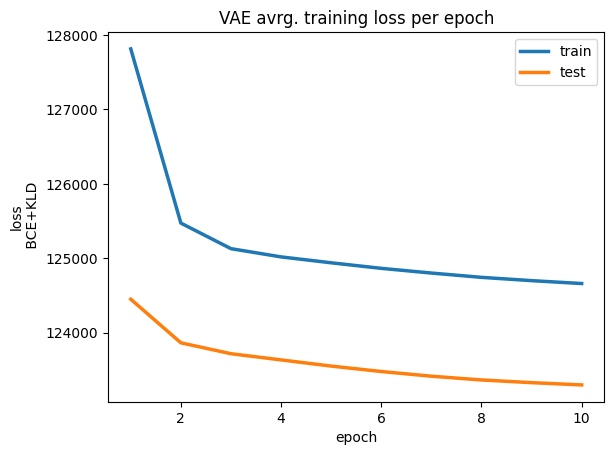

In [33]:
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in train_loss_vals_total], lw=2.5, label="train")
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in test_loss_vals_total], lw=2.5, label="test")
plt.xlabel("epoch")
plt.ylabel("loss\n BCE+KLD")
# plt.yscale("log")
plt.title("VAE avrg. training loss per epoch")
plt.legend()
plt.show()

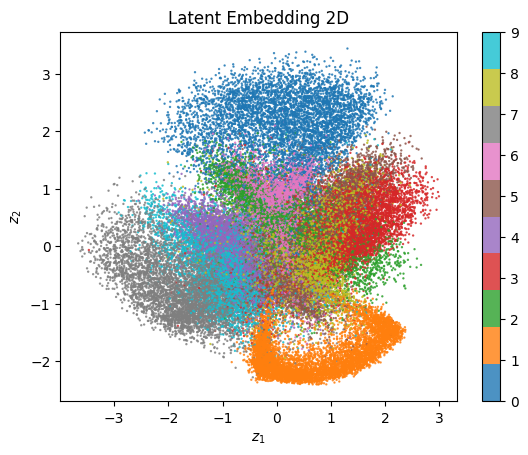

In [34]:
# encode entries
latent_coordinates = []
for data in train_data:
    # NOTE: we only obtain the mean for encoding and discard the log var
    latent_coordinates.append(model.encode(torch.Tensor(data).to(DEVICE))[0].cpu().detach().numpy())
latent_coordinates = np.array(latent_coordinates)

# visualize 2D embedding of MNIST
plt.scatter(latent_coordinates[:,0], latent_coordinates[:,1], alpha=.8, s=0.5, c=train_labels, cmap="tab10")
plt.xlabel(r"$z_1$")
plt.ylabel(r"$z_2$")
plt.colorbar()
plt.title("Latent Embedding 2D")
plt.show()

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


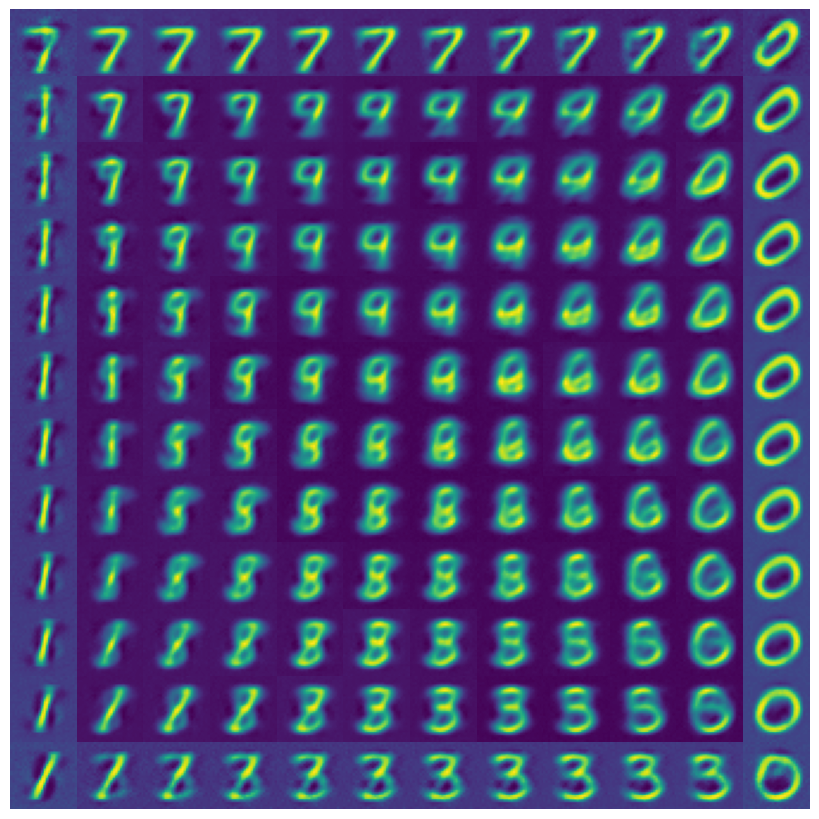

In [35]:
## 2.) visualize across Gaussian CDF
n_cols = 12
z_space = torch.linspace(0.0001, 0.9999, n_cols) # for 5x5 grid
std_gauss = torch.distributions.normal.Normal(0, 1)

xx, yy = torch.meshgrid(z_space, z_space)

zz_gauss_cdf_vals = torch.dstack([std_gauss.icdf(xx), std_gauss.icdf(yy)]).reshape(-1, 2)
zz_gauss_cdf_vals.shape

fig, ax = plt.subplots(nrows=n_cols, ncols=n_cols, figsize=(8,8))

k = 0
for i in range(n_cols):
    for j in range(n_cols):
        _zz = zz_gauss_cdf_vals[k]
        reconstruction = model.decode(_zz.to(DEVICE)).cpu().detach().numpy()
        img = reconstruction.reshape((28,28))
        ax[i, j].imshow(img)
        ax[i, j].set_axis_off()
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        k += 1
# plt.suptitle("MNIST reconstruction")
plt.tight_layout(w_pad=0., pad=0., h_pad=0.)
plt.show()

In [3]:
import torch
from torch import nn
import torch.nn.functional as F
from typing import Tuple

class VAE_beta(nn.Module):
    def __init__(self, hidden_dims, data_dim=784, device='cpu'):
        super().__init__()
        assert len(hidden_dims) == 5, "Insufficient number of dimensions!"
        self.data_dim = data_dim
        self.device = device

        # Define IO
        self.in_layer = nn.Linear(data_dim, hidden_dims[0])
        self.out_layer_alpha = nn.Linear(hidden_dims[-1], data_dim)
        self.out_layer_beta = nn.Linear(hidden_dims[-1], data_dim)

        # Hidden layers for encoder
        self.enc_h = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.enc_mu = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.enc_sigma = nn.Linear(hidden_dims[1], hidden_dims[2])

        # Hidden layers for decoder
        self.dec_h = nn.Linear(hidden_dims[2], hidden_dims[-2])
        self.dec_layer = nn.Linear(hidden_dims[-2], hidden_dims[-1])

        # Initialize weights
        self.init_weights()

        self.to(device)

    def init_weights(self):
        # Initialize weights for the alpha and beta layers
        nn.init.xavier_uniform_(self.out_layer_alpha.weight)
        nn.init.xavier_uniform_(self.out_layer_beta.weight)

        # Initialize biases for alpha and beta layers
        nn.init.constant_(self.out_layer_alpha.bias, 1.0)
        nn.init.constant_(self.out_layer_beta.bias, 1.0)

    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        h1 = F.relu(self.in_layer(x))
        h2 = F.relu(self.enc_h(h1))
        return self.enc_mu(h2), self.enc_sigma(h2)

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        h3 = F.relu(self.dec_h(z))
        h4 = F.relu(self.dec_layer(h3))
        alpha = F.softplus(self.out_layer_alpha(h4)) + 1e-6
        beta = F.softplus(self.out_layer_beta(h4)) + 1e-6
        # Constrain alpha and beta to avoid extreme values
        alpha = torch.clamp(alpha, min=1e-4, max=3)
        beta = torch.clamp(beta, min=1e-4, max=3)

        return alpha, beta

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        mu, logvar = self.encode(x.view(-1, self.data_dim))
        z = self.reparameterize(mu, logvar)
        alpha, beta = self.decode(z)
        return alpha, beta, mu, logvar



In [4]:
def train_beta(model: VAE_beta, epoch: int, train_loader: torch.utils.data.DataLoader, log_interval: int=25) -> list:
    model.train()
    train_loss = 0.
    train_loss_vals = []
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(model.device)
        optimizer.zero_grad()
        alpha, beta, mu, logvar = model(x)
        #print(f"Alpha mean: {alpha.mean()}, Beta mean: {beta.mean()}")
        loss_val, ce, kld = loss(alpha, beta, x, mu, logvar)
        loss_val.backward()
        train_loss += loss_val.item()
        train_loss_vals.append(loss_val.item())
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(f"Train epoch={epoch} [{batch_idx*len(x)}/{len(train_loader.dataset)}]\t loss={loss_val.item() / len(x)}")
            print(f"BCE={ce} KLD={kld}")
    print(f"===> epoch={epoch} avrg.loss={train_loss/len(train_loader.dataset)}")
    return train_loss_vals

In [5]:
def test_beta(model: VAE_beta, epoch: int, test_loader: torch.utils.data.DataLoader) -> list:
    model.eval()
    test_loss = 0.
    test_loss_vals = []
    with torch.no_grad():
        for i, (x, _) in enumerate(test_loader):
            x = x.to(model.device)
            alpha, beta, mu, logvar = model(x)
            test_loss_val, ce, kld = loss(alpha, beta, x, mu, logvar)
            test_loss += test_loss_val.item()
            test_loss_vals.append(test_loss_val.item())
            # if i == 0: # TODO: do we want to persist images here?
            #     n = min(data.size(0), 8)
            #     comparison = torch.cat([x[:n], ])
    test_loss /= len(test_loader.dataset)
    print(f"===> Test loss={test_loss}")
    return test_loss_vals

In [12]:
def beta_dist_neg_log_likelihood(alpha, beta, x):
    # Ensure alpha and beta are positive
    alpha = torch.clamp(alpha, min=1e-6)
    beta = torch.clamp(beta, min=1e-6)

    # Beta distribution
    beta_dist = torch.distributions.Beta(alpha, beta)

    # Negative log likelihood
    neg_log_likelihood = -beta_dist.log_prob(x)

    #print("Log prob min:", neg_log_likelihood.min().item(), "max:", neg_log_likelihood.max().item())

    return torch.sum(neg_log_likelihood)


In [9]:
def beta_reconstruction_loss(recon_alpha, recon_beta, x, eps=1e-5):
    recon_alpha = torch.clamp(recon_alpha, min=eps)
    recon_beta = torch.clamp(recon_beta, min=eps)
    x = torch.clamp(x, min=eps, max=1-eps)

    log_prob_x = torch.log(x)
    log_prob_1_minus_x = torch.log(1 - x)
    recon_loss = -torch.mean((recon_alpha - 1) * log_prob_x + (recon_beta - 1) * log_prob_1_minus_x)
    #print(log_prob_x, log_prob_1_minus_x, recon_loss)
    return recon_loss


def loss1(recon_alpha, recon_beta, x, mean, logvar):
    # Beta Reconstruction Loss
    eps = 1e-10  # To prevent log(0)
    recon_loss = beta_reconstruction_loss(recon_alpha, recon_beta, x)
    # KL Divergence
    kl_div = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp(), dim=1)
    kl_div = torch.mean(kl_div)

    return recon_loss + kl_div, recon_loss, kl_div

In [79]:
def beta_vae_loss(alpha, beta, x, mu, logvar):
    beta_dist = torch.distributions.Beta(alpha, beta)
    log_prob = beta_dist.log_prob(x)

    print("Log prob min:", log_prob.min().item(), "max:", log_prob.max().item())

    recon_loss = -torch.mean(log_prob)

    return recon_loss



In [13]:
#torch.autograd.set_detect_anomaly(True) # see where nan produced in code

EPOCHS=10

# 3.) modify the network architecture and try to obtain a better embedding
model_beta = VAE_beta(hidden_dims=[512, 256, 2, 256, 512]) # NOTE: 2D latent space

optimizer = optim.Adam(model_beta.parameters(), lr=1e-4)


def loss(alpha: torch.Tensor, beta: torch.Tensor, x: torch.Tensor, mu: torch.Tensor, logvar: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    #assert recon_x.shape[0] == x.shape[0] and recon_x.shape[-1] == x.shape[-1], "Shape Mismatch between reconstruction and x"
    #BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="sum")
    #BCE = neg_log_likelihood_cont_bernoulli(x.view(-1,784), recon_x)
    x_clamped = x.clamp(min=1e-4, max=1 - 1e-4)
    BCE = beta_dist_neg_log_likelihood(alpha, beta, x_clamped)
    #BCE = beta_vae_loss(alpha, beta, x, mu, logvar)
    KLD = -1/2 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    #print(BCE, KLD)
    return BCE + KLD, BCE, KLD # = -ELBO


train_loss_vals_total = []
test_loss_vals_total = []
for e in range(1, EPOCHS+1):
    train_loss_vals = train_beta(model_beta, epoch=e, train_loader=train_loader)
    test_loss_vals = test_beta(model_beta, epoch=e, test_loader=test_loader)
    train_loss_vals_total.append(train_loss_vals)
    test_loss_vals_total.append(test_loss_vals)

Train epoch=1 [0/60000]	 loss=175.54510498046875
BCE=44938.9765625 KLD=0.5709408521652222
Train epoch=1 [6400/60000]	 loss=-87.62267303466797
BCE=-22622.064453125 KLD=190.65980529785156
Train epoch=1 [12800/60000]	 loss=-390.70623779296875
BCE=-101483.796875 KLD=1463.002197265625
Train epoch=1 [19200/60000]	 loss=-500.14202880859375
BCE=-130101.40625 KLD=2065.049072265625
Train epoch=1 [25600/60000]	 loss=-497.6825866699219
BCE=-128805.703125 KLD=1398.9603271484375
Train epoch=1 [32000/60000]	 loss=-506.4537048339844
BCE=-130656.1015625 KLD=1003.9551391601562
Train epoch=1 [38400/60000]	 loss=-503.65545654296875
BCE=-129912.09375 KLD=976.2946166992188
Train epoch=1 [44800/60000]	 loss=-505.36224365234375
BCE=-130275.1171875 KLD=902.3849487304688
Train epoch=1 [51200/60000]	 loss=-505.4549255371094
BCE=-130248.046875 KLD=851.5845947265625
Train epoch=1 [57600/60000]	 loss=-514.8030395507812
BCE=-132641.96875 KLD=852.396484375
===> epoch=1 avrg.loss=-411.2515193400065
===> Test loss=-522

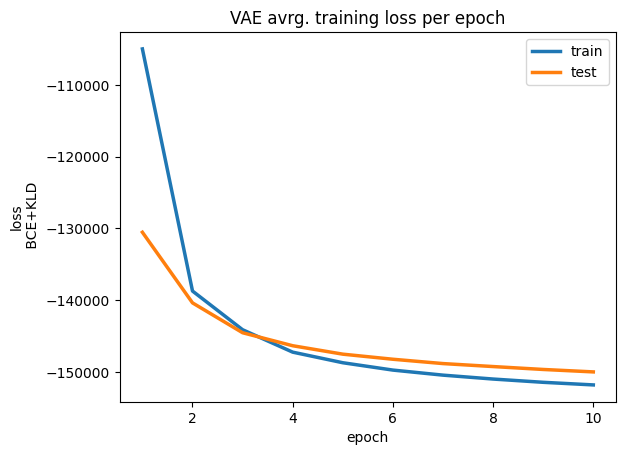

In [14]:
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in train_loss_vals_total], lw=2.5, label="train")
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in test_loss_vals_total], lw=2.5, label="test")
plt.xlabel("epoch")
plt.ylabel("loss\n BCE+KLD")
# plt.yscale("log")
plt.title("VAE avrg. training loss per epoch")
plt.legend()
plt.show()

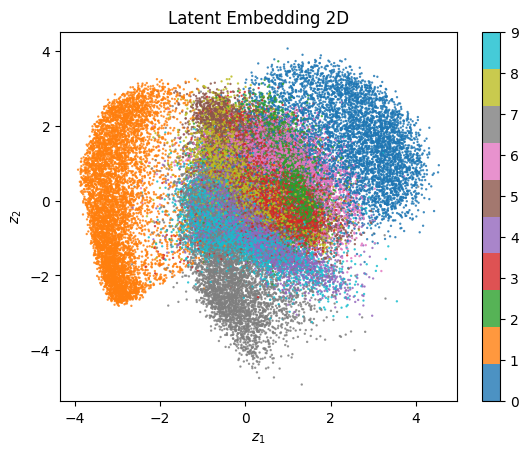

In [15]:
model_beta.to(DEVICE)
# encode entries
latent_coordinates = []
for data in train_data:
    # NOTE: we only obtain the mean for encoding and discard the log var
    latent_coordinates.append(model_beta.encode(torch.Tensor(data).to(DEVICE))[0].cpu().detach().numpy())
latent_coordinates = np.array(latent_coordinates)

# visualize 2D embedding of MNIST
plt.scatter(latent_coordinates[:,0], latent_coordinates[:,1], alpha=.8, s=0.5, c=train_labels, cmap="tab10")
plt.xlabel(r"$z_1$")
plt.ylabel(r"$z_2$")
plt.colorbar()
plt.title("Latent Embedding 2D")
plt.show()

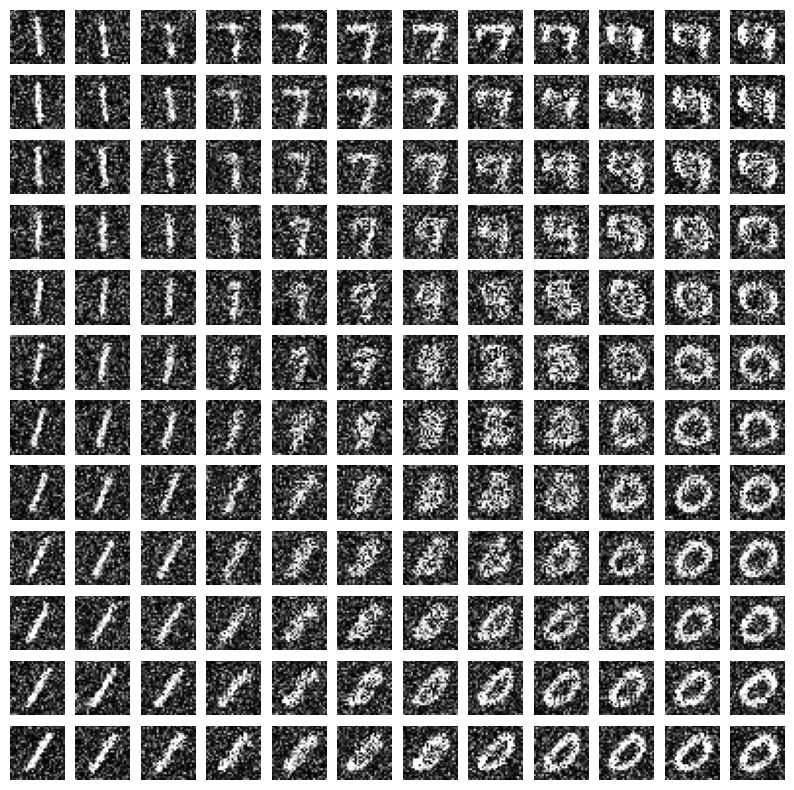

In [21]:
import torch
from torch.distributions import Beta

# Assuming the latent space is 2D
n = 12  # Number of images per dimension
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)

plt.figure(figsize=(10, 10))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = torch.from_numpy(z_sample).float().to(DEVICE)

        # Decode the sample
        alpha, beta = model_beta.decode(z_sample)
        alpha, beta = alpha.cpu(), beta.cpu()

        # Sample from the Beta distribution
        beta_dist = Beta(alpha, beta)
        decoded_sample = beta_dist.sample().detach().numpy()
        image = decoded_sample.reshape(28, 28)  # Assuming MNIST (28x28 images)

        plt.subplot(n, n, i * n + j + 1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')

plt.show()


In [23]:
#torch.autograd.set_detect_anomaly(True) # see where nan produced in code

EPOCHS=10

# 3.) modify the network architecture and try to obtain a better embedding
model_beta_large = VAE_beta(hidden_dims=[512, 256, 64, 256, 512]) # NOTE: 2D latent space

optimizer = optim.Adam(model_beta_large.parameters(), lr=1e-4)


def loss(alpha: torch.Tensor, beta: torch.Tensor, x: torch.Tensor, mu: torch.Tensor, logvar: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    #assert recon_x.shape[0] == x.shape[0] and recon_x.shape[-1] == x.shape[-1], "Shape Mismatch between reconstruction and x"
    #BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="sum")
    #BCE = neg_log_likelihood_cont_bernoulli(x.view(-1,784), recon_x)
    x_clamped = x.clamp(min=1e-4, max=1 - 1e-4)
    BCE = beta_dist_neg_log_likelihood(alpha, beta, x_clamped)
    #BCE = beta_vae_loss(alpha, beta, x, mu, logvar)
    KLD = -1/2 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    #print(BCE, KLD)
    return BCE + KLD, BCE, KLD # = -ELBO


train_loss_vals_total_large = []
test_loss_vals_total_large = []
for e in range(1, EPOCHS+1):
    train_loss_vals_large = train_beta(model_beta_large, epoch=e, train_loader=train_loader)
    test_loss_vals_large  = test_beta(model_beta_large, epoch=e, test_loader=test_loader)
    train_loss_vals_total_large.append(train_loss_vals)
    test_loss_vals_total_large.append(test_loss_vals)

Train epoch=1 [0/60000]	 loss=170.00868225097656
BCE=43488.2578125 KLD=33.965118408203125
Train epoch=1 [6400/60000]	 loss=-26.24379539489746
BCE=-7195.97509765625 KLD=477.5632629394531
Train epoch=1 [12800/60000]	 loss=-359.71392822265625
BCE=-99247.28125 KLD=7160.515625
Train epoch=1 [19200/60000]	 loss=-466.0210876464844
BCE=-121252.03125 KLD=1950.630615234375
Train epoch=1 [25600/60000]	 loss=-493.3930969238281
BCE=-127157.46875 KLD=848.8380737304688
Train epoch=1 [32000/60000]	 loss=-495.1770935058594
BCE=-126995.1953125 KLD=229.85769653320312
Train epoch=1 [38400/60000]	 loss=-503.49365234375
BCE=-128961.421875 KLD=67.04817199707031
Train epoch=1 [44800/60000]	 loss=-498.4302978515625
BCE=-127667.34375 KLD=69.18726348876953
Train epoch=1 [51200/60000]	 loss=-501.38543701171875
BCE=-128479.1328125 KLD=124.46107482910156
Train epoch=1 [57600/60000]	 loss=-506.446044921875
BCE=-129857.0625 KLD=206.87794494628906
===> epoch=1 avrg.loss=-395.2556836613973
===> Test loss=-511.062291796

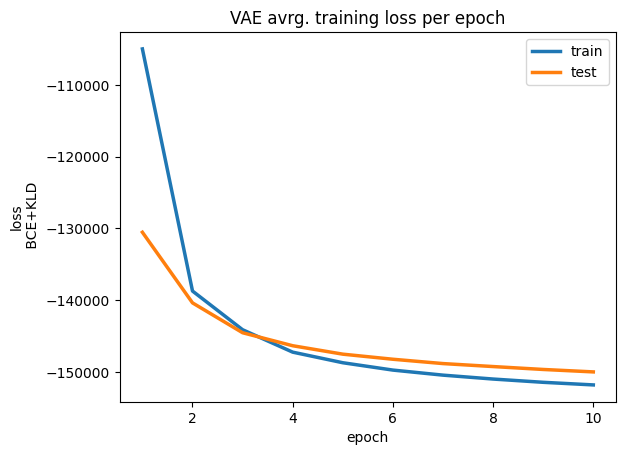

In [24]:
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in train_loss_vals_total], lw=2.5, label="train")
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in test_loss_vals_total], lw=2.5, label="test")
plt.xlabel("epoch")
plt.ylabel("loss\n BCE+KLD")
# plt.yscale("log")
plt.title("VAE avrg. training loss per epoch")
plt.legend()
plt.show()